# Selbstgebautes Modell

## Vorbereitung

### Bibliotheken und Module laden

In [1]:
!pip install -q kagglehub
!pip install -q pillow matplotlib numpy pandas

import kagglehub
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import psutil, os, time
from tensorflow.keras import mixed_precision
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
# mixed_precision.set_global_policy("mixed_float16")

2026-01-09 10:05:06.139710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-09 10:05:06.157022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-09 10:05:06.162408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-09 10:05:06.175506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-09 10:05:06.969357: W tensorflow/compiler/tf2

### Herunterladen und Ausgeben der Daten

Dataset-Pfad: /home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3

Erste Ebene im Dataset:
['frames', 'labels.npy', 'labels.csv', 'images.npy']

Erste 5 Zeilen der Labels:
   id  count
0   1     35
1   2     41
2   3     41
3   4     44
4   5     41

Shape der images.npy: (2000, 480, 640, 3)
Shape der labels.npy: (2000, 1)


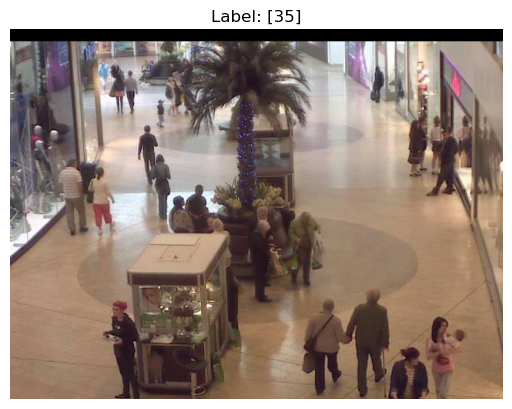


Gefundene Bilddateien im frames-Ordner: 2000
Beispiele: ['/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000895.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000891.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000860.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000862.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000937.jpg']


In [2]:
# Dataset von Kaggle herunterladen
base_path = kagglehub.dataset_download("fmena14/crowd-counting")
print("Dataset-Pfad:", base_path)

# Inhalt des Dataset-Ordners anzeigen (erste Ebene)
print("\nErste Ebene im Dataset:")
print(os.listdir(base_path))

# CSV-Datei mit Labels laden
csv_path = os.path.join(base_path, "labels.csv")
df_labels = pd.read_csv(csv_path)
print("\nErste 5 Zeilen der Labels:")
print(df_labels.head())

# .npy Dateien laden (Bilder und Labels)
images_path = os.path.join(base_path, "images.npy")
labels_path = os.path.join(base_path, "labels.npy")

# NumPy Arrays einlesen
images = np.load(images_path)
labels = np.load(labels_path)

# Form der Arrays ausgeben (Anzahl Bilder, Höhe, Breite, Kanäle)
print("\nShape der images.npy:", images.shape)
print("Shape der labels.npy:", labels.shape)

# Erstes Bild anzeigen
plt.imshow(images[0])                        # Bild darstellen
plt.title(f"Label: {labels[0]}")            # Titel mit dem Label setzen
plt.axis("off")                              # Achsen ausblenden
plt.show()

# Bilder aus dem 'frames'-Ordner laden (rekursiv durch Unterordner)
frames_path = os.path.join(base_path, "frames")

# Liste aller Bilddateien erstellen
image_files = []
for root, dirs, files in os.walk(frames_path):          # Durch alle Unterordner gehen
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):  # Nur Bilddateien
            image_files.append(os.path.join(root, f))     # Vollständigen Pfad speichern

# Anzahl gefundener Bilddateien ausgeben und Beispiele zeigen
print(f"\nGefundene Bilddateien im frames-Ordner: {len(image_files)}")
print("Beispiele:", image_files[:5])

In [3]:
# Annahme: Spalte heißt "count"
counts = df_labels["count"]

# Häufigkeit jeder Personenanzahl
value_counts = counts.value_counts().sort_index()

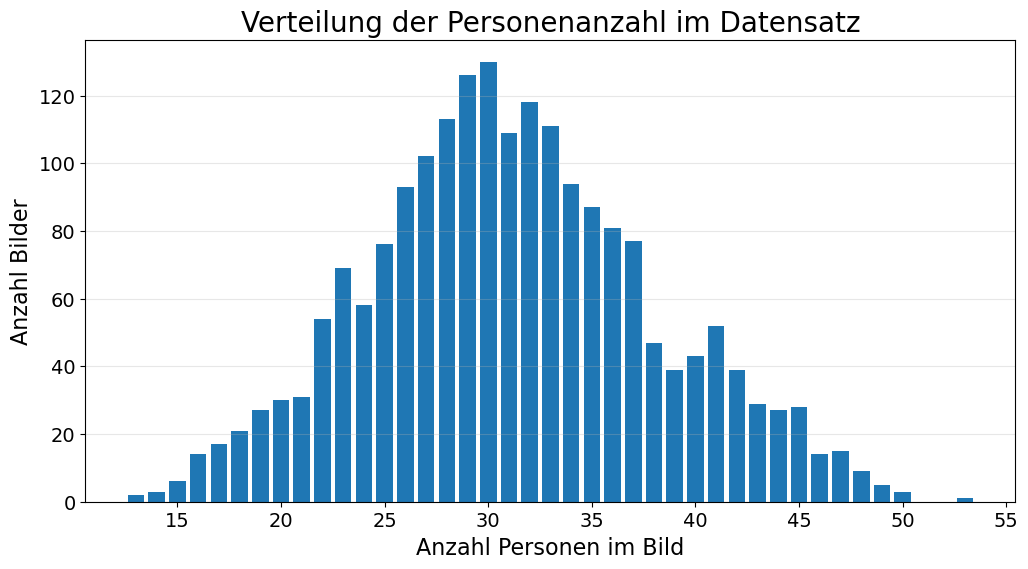

In [4]:
# Erstellung der Visualisierung der Daten

plt.figure(figsize=(12, 6))
plt.bar(value_counts.index, value_counts.values)

plt.xlabel("Anzahl Personen im Bild", fontsize=16) # X-Achse
plt.ylabel("Anzahl Bilder", fontsize=16) # Y-Achse
plt.title("Verteilung der Personenanzahl im Datensatz", fontsize=20) # Titel
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.grid(axis="y", alpha=0.3)

plt.show()

### Erstellen der Klassen 

In [6]:
# df_labels: DataFrame mit Spalte "count" (Anzahl Personen)
label_df = df_labels.copy()
label_df.rename(columns={"count": "people"}, inplace=True)

people = label_df["people"].values
print("Beispiele:", people[:5]) # Ausgabe der ersten fünf Inhalte

Beispiele: [35 41 41 44 41]


In [7]:
def to_classes(y):
    """
    Wandelt eine Zahl oder ein Array von Zahlen in diskrete Klassen um.

    Klassenaufteilung:
    0: 0–10 Personen
    1: 11–20 Personen
    2: 21–30 Personen
    3: 31–40 Personen
    4: mehr als 40 Personen

    Parameter:
    ----------
    y : int, float oder np.ndarray
        Anzahl der Personen oder ein Array von Personen-Zahlen.

    Rückgabe:
    -------
    np.ndarray
        Array von Ganzzahlen (0–4), die die jeweilige Klasse darstellen.
    """
    
    # np.select prüft die Bedingungen in der Liste nacheinander
    # und weist die entsprechenden Werte aus der zweiten Liste zu
    return np.select(
        [
            y <= 10,                      # Bedingung für Klasse 0
            (y > 10) & (y <= 20),         # Bedingung für Klasse 1
            (y > 20) & (y <= 30),         # Bedingung für Klasse 2
            (y > 30) & (y <= 40),         # Bedingung für Klasse 3
            y > 40                        # Bedingung für Klasse 4
        ],
        [0, 1, 2, 3, 4]                  # Werte, die den Klassen entsprechen
    ).astype("int64")                    # In Ganzzahlen umwandeln

# Beispiel: Menschenanzahlen in Klassen umwandeln
# 'people' ist ein Array oder eine Liste mit Zahlen
y_ordinal = to_classes(people)

# Erste 5 Werte ausgeben
print("Beispiele:", y_ordinal[:5])

Beispiele: [3 4 4 4 4]


### Train & Testsplit

In [7]:
# Reproduzierbarkeit sicherstellen
SEED = 42

In [8]:
# Trainings- und Testdaten aufteilen
x_train, x_test, y_train, y_test = train_test_split(
    images,         # Eingabebilder
    people,         # Zielwerte (Anzahl der Personen)
    random_state=SEED,  # Zufallsgenerator für reproduzierbare Ergebnisse
    test_size=0.1,       # X% der Daten als Testdatenset
)

# Bilder normalisieren: Werte von 0–255 auf 0–1 skalieren
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Anzahl der Trainings- und Testbilder ausgeben
print("Anzahl Trainingsbilder: ", len(x_train))
print("Anzahl Testsbilder: ", len(x_test))

Anzahl Trainingsbilder:  1800
Anzahl Testsbilder:  200


## Neuronales Netz erstellen

### Grundstruktur erstellen

In [ ]:
import tensorflow as tf

# Sequential-Modell erstellen (Schichten werden nacheinander ausgeführt)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(480, 640, 3)),  # Eingabeschicht: erwartet Bilder der Größe 480x640 mit 3 Farbkanälen (RGB)
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="linear")
])

# Modellübersicht anzeigen: Anzahl der Parameter pro Schicht
model.summary()

### Kompilieren des Modells

In [10]:
model.compile(
    optimizer="adam", # Standard optimizer
    loss="mae",        # oder "mse" -> MAE aber robuster gegenüber Ausreissern
    metrics=["mae"]
)

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)   # Wenn das Modell nach fünf Epochen keinen Fortschritt mehr erzielt, soll die Berechnung abgebrochen werden

### Trainieren des Modells

In [12]:
history = model.fit(
    x_train,
    y_train,                 # y_train = Personenzahl
    validation_data=(x_test, y_test),
    epochs=30,    
    batch_size=8, # Aufgrund von fehlendem RAM nur mit 8 und nicht 16 oder 32
    callbacks=[early_stopping],
    verbose=1
)

2026-01-09 09:19:41.456165: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6635520000 exceeds 10% of free system memory.
2026-01-09 09:19:44.992792: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6635520000 exceeds 10% of free system memory.


Epoch 1/30


I0000 00:00:1767950388.459124     564 service.cc:146] XLA service 0x7fb3fc10f8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767950388.459534     564 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2026-01-09 09:19:51.338590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-09 09:19:51.555577: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2026-01-09 09:19:51.729248: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:21:50 22s/step - loss: 35.4011 - mae: 35.4011

I0000 00:00:1767950409.142433     564 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 10.9964 - mae: 10.9964 - val_loss: 6.0501 - val_mae: 6.0501
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - loss: 7.7184 - mae: 7.7184 - val_loss: 6.0588 - val_mae: 6.0588
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - loss: 7.0945 - mae: 7.0945 - val_loss: 6.0315 - val_mae: 6.0315
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 7.0503 - mae: 7.0503

2026-01-09 09:22:03.712524: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 29491264 bytes after encountering the first element of size 29491264 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - loss: 7.0491 - mae: 7.0491 - val_loss: 5.2570 - val_mae: 5.2570
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - loss: 6.8039 - mae: 6.8039 - val_loss: 5.6243 - val_mae: 5.6243
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 6.1865 - mae: 6.1865 - val_loss: 5.7239 - val_mae: 5.7239
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 6.2172 - mae: 6.2172 - val_loss: 6.0267 - val_mae: 6.0267
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 5.8089 - mae: 5.8089

2026-01-09 09:23:45.112513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 29491264 bytes after encountering the first element of size 29491264 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - loss: 5.8092 - mae: 5.8092 - val_loss: 5.3834 - val_mae: 5.3834
Epoch 9/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - loss: 6.3952 - mae: 6.3952 - val_loss: 4.5395 - val_mae: 4.5395
Epoch 10/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 5.7747 - mae: 5.7747 - val_loss: 4.5033 - val_mae: 4.5033
Epoch 11/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - loss: 5.8597 - mae: 5.8597 - val_loss: 4.3933 - val_mae: 4.3933
Epoch 12/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - loss: 5.7445 - mae: 5.7445 - val_loss: 4.4467 - val_mae: 4.4467
Epoch 13/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - loss: 5.6652 - mae: 5.6652 - val_loss: 4.3610 - val_mae: 4.3610
Epoch 14/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - loss: 5.6584 - mae: 5.6584 - val_loss: 5.4254 - val_mae: 5.4254
Epoch 15/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - loss: 5.8253 - mae: 5.8253 - val_loss: 4.4710 - val_mae: 4.4710
Epoch 16/30
225/225 ━━━━━━━━━━━━━━━━━

### Vorhersagen ausgeben und in Klassen umwandeln

In [13]:
predictions = model.predict(x_test)
print("Vorhersagen:", predictions[:5])

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step
Vorhersagen: [[29.086748]
 [28.466038]
 [31.63008 ]
 [36.64139 ]
 [29.026917]]


In [14]:
def to_classes(y):
    """
    Klassen:
    0: 0–10
    1: 11–20
    2: 21–30
    3: 31–40
    4: 40+
    """
    return np.select(
        [
            y <= 10,
            (y > 10) & (y <= 20),
            (y > 20) & (y <= 30),
            (y > 30) & (y <= 40),
            y > 40
        ],
        [0, 1, 2, 3, 4]  # Hinweis: 0-basierte Klassen
    ).astype("int64")

In [15]:
predictions = model.predict(x_test)
pred_classes = to_classes(predictions)
true_classes = to_classes(y_test)

accuracy = np.mean(pred_classes == true_classes)
print("Class Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
Class Accuracy: 0.399875


## Ausgeben der Trainingsresultate

Class Accuracy: 0.399875


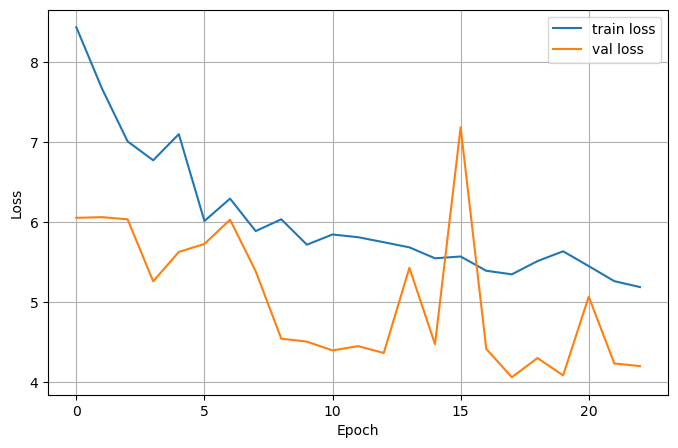

In [16]:
accuracy = np.mean(pred_classes == true_classes)
print("Class Accuracy:", accuracy)

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


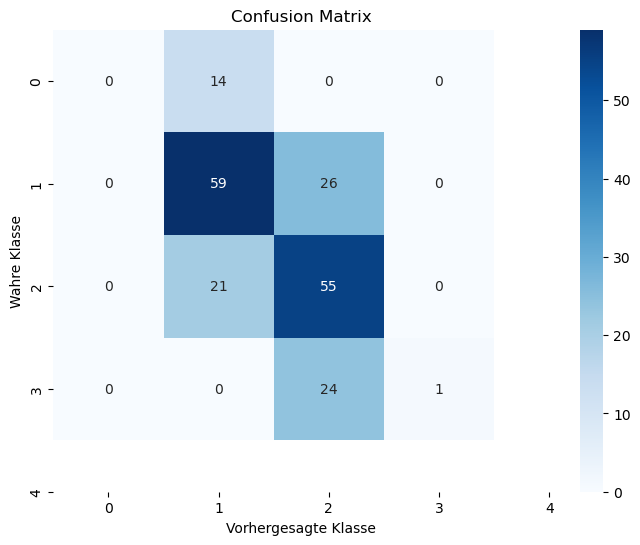

In [17]:
# Vorhersagen und true Klassen
pred_classes = to_classes(model.predict(x_test))
true_classes = to_classes(y_test)

# Confusion Matrix berechnen
cm = confusion_matrix(true_classes, pred_classes)

# Plotten
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Wahre Klasse")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Anzahl korrekt vorhergesagter Klassen
correct = np.trace(cm)  # Summe der Diagonale
total = np.sum(cm)
print(f"Anzahl korrekt vorhergesagter Samples: {correct} / {total}")
print(f"Accuracy: {correct/total:.4f}")

Anzahl korrekt vorhergesagter Samples: 112 / 200
Accuracy: 0.5600
